In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
#dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
#dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

mutation_arange = [np.round(x,2) for x in np.arange(0.1,1,0.2)]


startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,heterogeneousFleet=True)

In [3]:
    
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_plot2(data,variable_field,between_fields,path=None,save=False):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1,figsize=(15,15))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df.where(summary_df.reject == True,inplace=True)
    summary_df.dropna(inplace=True)
  
    
    optimal_params = extractOptimalParameters2(data,summary_df,1)
    if len(optimal_params) > 0:
        
        optimal_group = int(optimal_params.head(1)[between_fields]) or None
    else:
        optimal_group = None
    tukey.plot_simultaneous(figsize=(15,15),ax=ax,comparison_name =optimal_group )
    #ax.set_xlabel("Euclidean distance",fontsize=24)
    plt.yticks(range(0,45,2),range(0,45,2))
    #plt.yticks(range(0,5),range(0,5))
    ax.set_xlabel("Objective sum",fontsize=24)
    ax.set_ylabel("Parameter Group",fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    plt.title("")
    plt.savefig("anova_plot_{}.pdf".format(data.algorithm),bbox_inches='tight')
    plt.show()
    
    
    
    return summary_df ,fig, tukey
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov
def extractOptimalParameters2(resultsDataFrame,tukeyResult,amount=5):
    optimalParamGroups = tukeyResult.sort_values(by='meandiff').head(amount).group2
    resultDF = pd.DataFrame(columns=resultsDataFrame.columns)
    for group in optimalParamGroups:
        resultDF = pd.concat([resultDF,(resultsDataFrame.where(resultsDataFrame["Parameter Group"] == np.float(group))).dropna()],axis=0)
    return resultDF


In [4]:

def get_sorted_df(dataFrames):
    optimal_params_DF=pd.DataFrame()
    datasetNames = ["UK25_2","UK25_4","UK25_8","UK50_1","SA_50_2","SA_50_4","UK75_1","UK75_3","UK75_6"]
    for dataframe,datasetName in zip(dataFrames,datasetNames):
        
        dataframe_optimal = dataframe.groupby(by=["Parameter Group"]).mean().sort_values(by=["summation_minmax"]).head(1)
        dataframe_optimal["dataset"] = datasetName
        optimal_params_DF = pd.concat([optimal_params_DF,dataframe_optimal])
    return optimal_params_DF#.groupby("Parameter Group").head()
    


In [5]:
def process_log_data(dataframes):
    for df in dataframes:
        add_final_fitness_columns(df)
        expand_parameter_colums(df)
        add_distance_to_origin(df)
        df["vehicle_amount"] = df.vehicle_route_time.apply(len)
        df["total_route_time"] = df.vehicle_route_time.apply(sum)/(60**2)

        df["gini_index"] = get_gini_coefficients(df) #* np.array([math.ceil(df.fuel_consumption[0][0] /100) * 100]*45*30)
        gini_scale =  np.array([math.ceil(df.fuel_consumption[0][0] /100) * 100]*45*30)
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)

        summation = df.fuel_consumption_final + df.total_route_time + (df.gini_index*gini_scale)
        max_distance_to_origin = max(summation)
        min_distance_to_origin = min(summation)
        df["summation_minmax"] = (( df.fuel_consumption_final + df.total_route_time + (df.gini_index * gini_scale)) - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    return pd.concat(dataframes)
    

# NSGAII

In [6]:
NSGA2_25_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_2/NSGA2.csv")
NSGA2_25_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_4/NSGA2.csv")
NSGA2_25_8 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_8/NSGA2.csv")
NSGA2_50_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_1/NSGA2.csv")
NSGA2_50_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_2/NSGA2.csv")
NSGA2_50_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_4/NSGA2.csv")
NSGA2_75_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_1/NSGA2.csv")
NSGA2_75_3 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_3/NSGA2.csv")
NSGA2_75_6 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_6/NSGA2.csv")


combined_NSGA2 = [NSGA2_25_2,NSGA2_25_4,NSGA2_25_8,NSGA2_50_1,NSGA2_50_2,NSGA2_50_4,NSGA2_75_1,NSGA2_75_3,NSGA2_75_6]

    
NSGA2_data =process_log_data(combined_NSGA2)# pd.concat(combined_NSGA2)
    

In [7]:
optimal_params_NSGA2 = get_sorted_df(combined_NSGA2)
optimal_params_NSGA2

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
41.0,14.5,218.083159,69.249716,206.650000,0.9,0.50,30.0,3.033333,9.021537,0.059579,0.138188,0.090139,UK25_2
34.0,14.5,456.861018,242.366694,387.187778,0.7,0.75,20.0,5.000000,19.660167,0.294960,0.083300,0.108593,UK25_4
43.0,14.5,265.417684,108.948903,241.973333,0.9,0.75,20.0,4.000000,14.146102,0.058517,0.213390,0.111080,UK25_8
32.0,14.5,336.029820,215.386925,255.880556,0.7,0.50,30.0,9.233333,28.178722,0.129181,0.219270,0.128810,UK50_1
35.0,14.5,338.695384,182.415839,285.137778,0.7,0.75,30.0,6.333333,23.976824,0.100598,0.203226,0.189265,SA_50_2
41.0,14.5,302.100266,173.658940,247.190000,0.9,0.50,30.0,8.000000,24.062454,0.173324,0.224007,0.160712,SA_50_4
35.0,14.5,663.906624,482.579852,454.970000,0.7,0.75,30.0,10.500000,52.926000,0.193910,0.149749,0.148637,UK75_1
32.0,14.5,403.730138,241.837642,322.273333,0.7,0.50,30.0,12.166667,35.903000,0.251323,0.094023,0.062084,UK75_3
35.0,14.5,475.994581,343.039286,329.266111,0.7,0.75,30.0,11.600000,40.178463,0.177696,0.120029,0.141946,UK75_6


In [8]:
optimal_params_NSGA2.total_route_time*60

Parameter Group
41.0     541.292222
34.0    1179.610000
43.0     848.766111
32.0    1690.723333
35.0    1438.609444
41.0    1443.747222
35.0    3175.560000
32.0    2154.180000
35.0    2410.707778
Name: total_route_time, dtype: float64

In [9]:
NSGA2_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
32.0,14.5,387.229058,230.032471,305.590802,0.7,0.50,30.0,7.748148,27.640642,0.160225,0.168369,0.136041
35.0,14.5,387.165832,229.682583,305.915247,0.7,0.75,30.0,7.770370,27.615322,0.160662,0.170737,0.139556
44.0,14.5,388.567329,231.525971,306.287222,0.9,0.75,30.0,7.785185,27.799165,0.159128,0.179941,0.143629
34.0,14.5,390.903597,231.236282,308.914815,0.7,0.75,20.0,7.762963,27.731497,0.164763,0.169308,0.148155
41.0,14.5,390.180499,232.392670,307.801914,0.9,0.50,30.0,7.751852,27.827051,0.159979,0.182954,0.151138
26.0,14.5,389.874117,230.985630,308.124630,0.5,0.75,30.0,7.777778,27.742544,0.163470,0.171307,0.151828
43.0,14.5,390.135179,231.983548,307.988519,0.9,0.75,20.0,7.733333,27.785192,0.161011,0.184648,0.152673
23.0,14.5,388.785881,233.479661,304.772963,0.5,0.50,30.0,7.874074,27.939082,0.159879,0.184167,0.153954
29.0,14.5,392.676558,233.864346,309.378086,0.7,0.25,30.0,7.829630,27.979358,0.163286,0.185985,0.158738


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



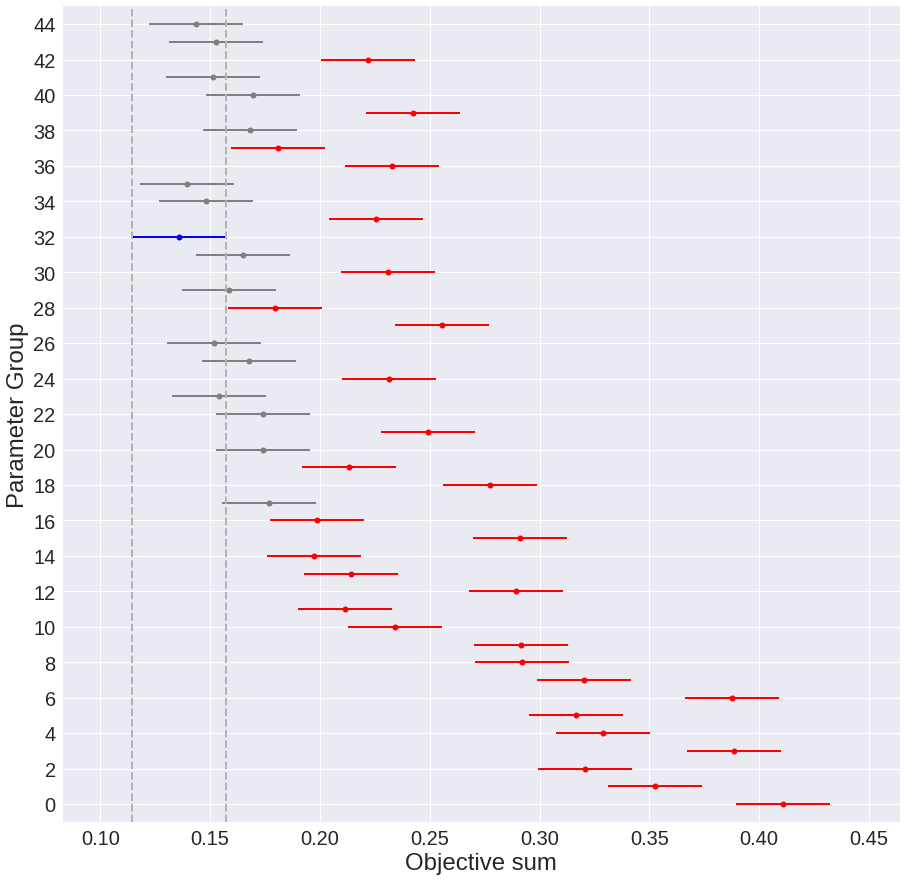

In [10]:
NSGA2_data.algorithm="NSGA2"
nsga2_data_tukey,fig,t = anova_plot2(NSGA2_data,'summation_minmax','Parameter Group')

# NSGAIII

In [11]:
NSGA3_25_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_2/NSGA3.csv")
NSGA3_25_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_4/NSGA3.csv")
NSGA3_25_8 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_8/NSGA3.csv")
NSGA3_50_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_1/NSGA3.csv")
NSGA3_50_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_2/NSGA3.csv")
NSGA3_50_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_4/NSGA3.csv")
NSGA3_75_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_1/NSGA3.csv")
NSGA3_75_3 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_3/NSGA3.csv")
NSGA3_75_6 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_6/NSGA3.csv")


combined_NSGA3 = [NSGA3_25_2,NSGA3_25_4,NSGA3_25_8,NSGA3_50_1,NSGA3_50_2,NSGA3_50_4,NSGA3_75_1,NSGA3_75_3,NSGA3_75_6]

NSGA3_data = process_log_data(combined_NSGA3)
   
    

In [12]:
get_sorted_df(combined_NSGA3)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
26.0,14.5,219.798574,69.039703,208.539444,0.5,0.75,30.0,3.066667,9.114324,0.063468,0.122201,0.103171,UK25_2
43.0,14.5,456.878536,247.101323,384.208333,0.9,0.75,20.0,5.000000,20.219787,0.279012,0.178761,0.126436,UK25_4
40.0,14.5,272.267809,111.031242,248.395556,0.9,0.50,20.0,3.933333,14.326806,0.053712,0.345927,0.137929,UK25_8
44.0,14.5,344.677378,218.110711,264.376667,0.9,0.75,30.0,9.233333,28.415583,0.125573,0.226594,0.115147,UK50_1
44.0,14.5,341.121368,182.245633,288.224444,0.9,0.75,30.0,6.200000,24.149037,0.091987,0.136550,0.127316,SA_50_2
40.0,14.5,302.611920,173.541865,247.890556,0.9,0.50,20.0,8.000000,24.102630,0.172507,0.194659,0.143115,SA_50_4
44.0,14.5,674.659446,495.585350,457.043889,0.9,0.75,30.0,10.533333,54.032602,0.185180,0.198992,0.182824,UK75_1
44.0,14.5,405.139725,242.156999,324.104444,0.9,0.75,30.0,12.000000,35.946426,0.250489,0.069357,0.038355,UK75_3
43.0,14.5,482.592798,346.346019,335.082222,0.9,0.75,20.0,11.200000,40.485509,0.172608,0.108409,0.118557,UK75_6


In [13]:
get_sorted_df(combined_NSGA3).total_route_time * 60

Parameter Group
26.0     546.859444
43.0    1213.187222
40.0     859.608333
44.0    1704.935000
44.0    1448.942222
40.0    1446.157778
44.0    3241.956111
44.0    2156.785556
43.0    2429.130556
Name: total_route_time, dtype: float64

In [14]:
NSGA3_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
44.0,14.5,388.568983,231.167083,306.585679,0.9,0.75,30.0,7.740741,27.826571,0.157710,0.174548,0.126486
35.0,14.5,389.840091,231.612429,307.793580,0.7,0.75,30.0,7.811111,27.842204,0.161377,0.175543,0.134312
41.0,14.5,390.519357,232.576503,307.861420,0.9,0.50,30.0,7.725926,27.847556,0.160191,0.181538,0.137221
34.0,14.5,389.199448,233.246843,305.709815,0.7,0.75,20.0,7.870370,28.051933,0.161585,0.179831,0.140095
43.0,14.5,391.704305,232.997534,308.817160,0.9,0.75,20.0,7.729630,28.030881,0.160665,0.179762,0.140747
40.0,14.5,392.070231,235.249605,307.496049,0.9,0.50,20.0,7.807407,28.184789,0.156107,0.196701,0.141603
26.0,14.5,390.524706,233.019781,307.133642,0.5,0.75,30.0,7.866667,27.903297,0.163893,0.178875,0.143872
32.0,14.5,393.368316,234.271672,310.326790,0.7,0.50,30.0,7.796296,28.031291,0.162085,0.186286,0.145061
31.0,14.5,392.246948,234.403800,308.255247,0.7,0.50,20.0,7.785185,28.065364,0.162629,0.179444,0.148527


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



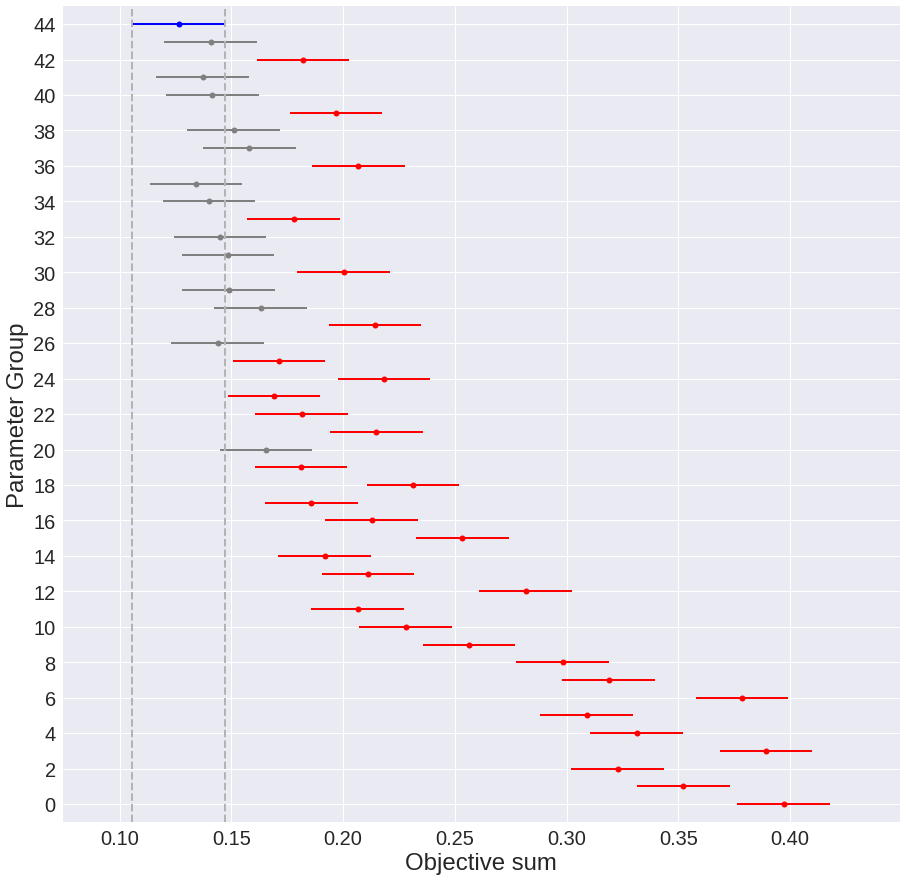

In [15]:
NSGA3_data.algorithm="NSGA3"
nsga3_data_tukey,fig,t = anova_plot2(NSGA3_data,'summation_minmax','Parameter Group')

# UNSGAII

In [16]:
UNSGA3_25_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_2/UNSGA3.csv")
UNSGA3_25_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_4/UNSGA3.csv")
UNSGA3_25_8 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_8/UNSGA3.csv")
UNSGA3_50_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_1/UNSGA3.csv")
UNSGA3_50_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_2/UNSGA3.csv")
UNSGA3_50_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_4/UNSGA3.csv")
UNSGA3_75_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_1/UNSGA3.csv")
UNSGA3_75_3 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_3/UNSGA3.csv")
UNSGA3_75_6 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_6/UNSGA3.csv")


combined_UNSGA3 = [UNSGA3_25_2,UNSGA3_25_4,UNSGA3_25_8,UNSGA3_50_1,UNSGA3_50_2,UNSGA3_50_4,UNSGA3_75_1,UNSGA3_75_3,UNSGA3_75_6]

UNSGA3_data = process_log_data(combined_UNSGA3)
    

In [17]:
get_sorted_df(combined_UNSGA3)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
38.0,14.5,222.566397,69.808541,211.250000,0.9,0.25,30.0,3.033333,9.099269,0.065757,0.100022,0.096406,UK25_2
26.0,14.5,459.549947,247.048871,387.388889,0.5,0.75,30.0,5.000000,20.189565,0.283185,0.163684,0.136706,UK25_4
44.0,14.5,270.718224,109.609561,247.301667,0.9,0.75,30.0,3.966667,14.139574,0.069683,0.351481,0.179349,UK25_8
44.0,14.5,351.196148,219.521596,271.919444,0.9,0.75,30.0,9.200000,28.583056,0.128415,0.201953,0.123668,UK50_1
44.0,14.5,342.328356,180.085221,290.898889,0.9,0.75,30.0,6.166667,23.614806,0.105235,0.117014,0.121192,SA_50_2
43.0,14.5,303.892965,173.125382,249.693889,0.9,0.75,20.0,7.966667,23.995167,0.175607,0.092900,0.088561,SA_50_4
41.0,14.5,680.778028,502.220743,458.975556,0.9,0.50,30.0,10.633333,54.764556,0.181793,0.200606,0.177796,UK75_1
44.0,14.5,397.373616,242.012022,313.843333,0.9,0.75,30.0,12.500000,35.998750,0.250602,0.057203,0.043396,UK75_3
35.0,14.5,477.254079,342.340492,332.016667,0.7,0.75,30.0,11.666667,40.389481,0.179182,0.116508,0.129033,UK75_6


In [18]:
UNSGA3_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
44.0,14.5,392.491738,233.506149,309.165494,0.9,0.75,30.0,7.803704,27.990242,0.160927,0.163399,0.131476
41.0,14.5,389.857344,232.696790,306.885123,0.9,0.50,30.0,7.888889,27.990507,0.162606,0.164453,0.138290
43.0,14.5,391.973539,236.639190,305.703025,0.9,0.75,20.0,7.859259,28.353187,0.159877,0.169811,0.139689
35.0,14.5,391.908742,234.388843,307.173086,0.7,0.75,30.0,7.870370,28.133799,0.163031,0.165969,0.139841
34.0,14.5,393.638205,234.465982,309.918457,0.7,0.75,20.0,7.818519,28.190034,0.164143,0.164115,0.142232
38.0,14.5,395.532737,236.466021,310.731296,0.9,0.25,30.0,7.762963,28.281231,0.160751,0.179808,0.146465
40.0,14.5,393.912219,235.715419,309.518951,0.9,0.50,20.0,7.777778,28.254530,0.161179,0.180220,0.149827
32.0,14.5,393.670981,236.247200,308.315556,0.7,0.50,30.0,7.918519,28.232752,0.163330,0.179336,0.154467
29.0,14.5,395.902934,235.422828,311.648086,0.7,0.25,30.0,7.848148,28.160174,0.167360,0.172041,0.155495


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



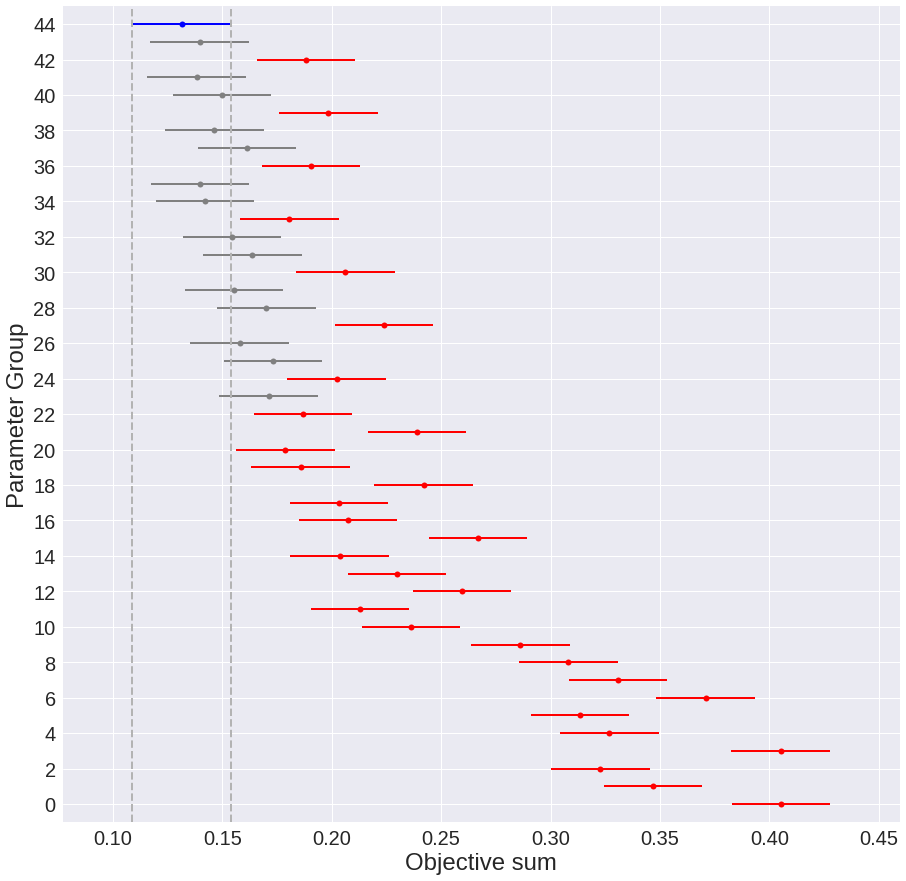

In [19]:
UNSGA3_data.algorithm="UNSGA3"
Unsga3_data_tukey,fig,t = anova_plot2(UNSGA3_data,'summation_minmax','Parameter Group')

# IBEA

In [20]:
IBEA_25_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_2/IBEA.csv")
IBEA_25_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_4/IBEA.csv")
IBEA_25_8 = pd.read_csv("parameter_data/Multi_Objective_Results/UK25_8/IBEA.csv")
IBEA_50_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_1/IBEA.csv")
IBEA_50_2 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_2/IBEA.csv")
IBEA_50_4 = pd.read_csv("parameter_data/Multi_Objective_Results/UK50_4/IBEA.csv")
IBEA_75_1 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_1/IBEA.csv")
IBEA_75_3 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_3/IBEA.csv")
IBEA_75_6 = pd.read_csv("parameter_data/Multi_Objective_Results/UK75_6/IBEA.csv")

combined_IBEA = [IBEA_25_2,IBEA_25_4,IBEA_25_8,IBEA_50_1,IBEA_50_2,IBEA_50_4,IBEA_75_1,IBEA_75_3,IBEA_75_6]

IBEA_data =process_log_data(combined_IBEA)
    

In [21]:
IBEA_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
35.0,14.5,377.205866,222.637310,299.605864,0.7,0.75,30.0,7.677778,27.342867,0.147144,0.194983,0.135962
34.0,14.5,377.846606,224.264498,298.904259,0.7,0.75,20.0,7.766667,27.532501,0.146493,0.198637,0.136375
25.0,14.5,376.821551,224.045481,297.723827,0.5,0.75,20.0,7.770370,27.512507,0.147986,0.201368,0.145750
43.0,14.5,379.349118,225.098582,300.144938,0.9,0.75,20.0,7.748148,27.577019,0.146515,0.206203,0.146926
42.0,14.5,379.827749,227.570416,298.810370,0.9,0.75,10.0,7.814815,27.980332,0.142646,0.223217,0.150938
41.0,14.5,381.638686,225.800320,302.456790,0.9,0.50,30.0,7.711111,27.512037,0.147837,0.209737,0.151287
31.0,14.5,377.872307,225.357336,297.944321,0.7,0.50,20.0,7.829630,27.617553,0.148502,0.210300,0.151442
32.0,14.5,380.144179,224.808384,301.296111,0.7,0.50,30.0,7.688889,27.457876,0.149219,0.205907,0.151887
26.0,14.5,377.496418,225.397007,297.480864,0.5,0.75,30.0,7.855556,27.564157,0.147977,0.213739,0.154914


In [25]:
get_sorted_df(combined_IBEA)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
34.0,14.5,216.465600,68.917838,205.120000,0.7,0.75,20.0,3.033333,9.131491,0.051173,0.204863,0.098980,UK25_2
42.0,14.5,449.278515,242.962076,377.832222,0.9,0.75,10.0,5.000000,20.124991,0.272895,0.142912,0.103364,UK25_4
31.0,14.5,264.785133,108.882084,241.327778,0.7,0.50,20.0,4.000000,14.331667,0.047059,0.342826,0.095748,UK25_8
42.0,14.5,323.075140,216.188663,238.745556,0.9,0.75,10.0,9.566667,28.591324,0.108597,0.329506,0.157779,UK50_1
35.0,14.5,331.701687,177.941304,279.898889,0.7,0.75,30.0,6.066667,23.905944,0.054396,0.161344,0.118842,SA_50_2
44.0,14.5,300.904679,171.155601,247.478889,0.9,0.75,30.0,8.000000,24.036972,0.173145,0.129499,0.117728,SA_50_4
35.0,14.5,639.332068,440.440047,463.226667,0.7,0.75,30.0,9.300000,49.512037,0.181528,0.180724,0.129530,UK75_1
43.0,14.5,386.047209,242.235269,299.193889,0.9,0.75,20.0,12.733333,36.496759,0.233766,0.109870,0.074024,UK75_3
35.0,14.5,465.753899,333.637995,324.434444,0.7,0.75,30.0,11.466667,40.368769,0.163687,0.118191,0.162931,UK75_6


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



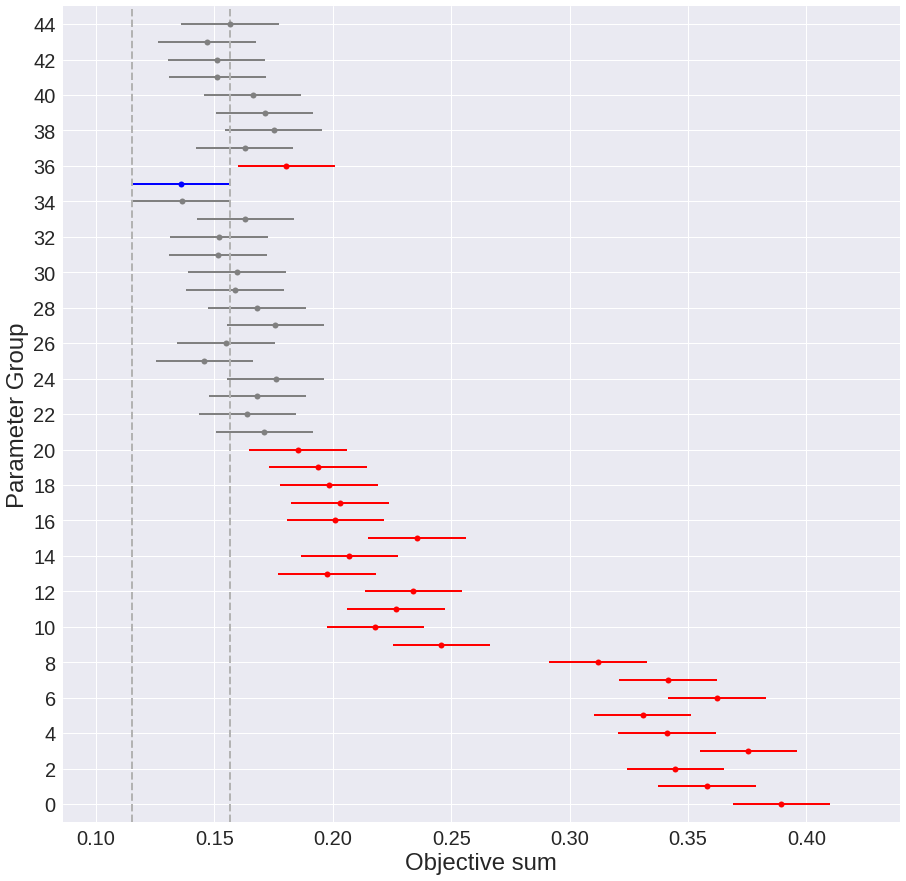

In [24]:
IBEA_data.algorithm="IBEA"
IBEA_data_tukey,fig,t = anova_plot2(IBEA_data,'summation_minmax','Parameter Group')